<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Set-Up-Constants,-Planet-Parameters-and-Arrays" data-toc-modified-id="Set-Up-Constants,-Planet-Parameters-and-Arrays-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Set-Up Constants, Planet Parameters and Arrays</a></span></li><li><span><a href="#Water-Saturation-Vapor-Pressure" data-toc-modified-id="Water-Saturation-Vapor-Pressure-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Water Saturation Vapor Pressure</a></span></li><li><span><a href="#Dry-Adiabat" data-toc-modified-id="Dry-Adiabat-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Dry Adiabat</a></span></li><li><span><a href="#Moist-Adiabat" data-toc-modified-id="Moist-Adiabat-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Moist Adiabat</a></span><ul class="toc-item"><li><span><a href="#Following-Marcq-papers" data-toc-modified-id="Following-Marcq-papers-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Following Marcq papers</a></span></li><li><span><a href="#Following-Pierrehumbert-Book" data-toc-modified-id="Following-Pierrehumbert-Book-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Following Pierrehumbert Book</a></span></li></ul></li><li><span><a href="#Isothermal-Region" data-toc-modified-id="Isothermal-Region-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Isothermal Region</a></span></li><li><span><a href="#Main-Loop" data-toc-modified-id="Main-Loop-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Main Loop</a></span></li><li><span><a href="#Set-Surface-Conditions-and-Run-Models" data-toc-modified-id="Set-Surface-Conditions-and-Run-Models-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Set Surface Conditions and Run Models</a></span></li><li><span><a href="#Plot-Results" data-toc-modified-id="Plot-Results-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Plot Results</a></span></li><li><span><a href="#ODE-with-Event-Finding-Approach" data-toc-modified-id="ODE-with-Event-Finding-Approach-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>ODE with Event-Finding Approach</a></span></li></ul></div>

In [5]:
import numpy as np
import pandas as pd 
import glob 
import os 
import scipy.integrate as integrate
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp

%matplotlib inline 
import matplotlib
import matplotlib.pyplot as plt
plt.rc("savefig", dpi=300)
plt.rc('figure', dpi=300)
plt.rc('text', usetex=True)
plt.rc('font', size=11)
plt.rc('xtick', direction='in') 
plt.rc('ytick', direction='in')
plt.rc('xtick.major', pad=5) 
plt.rc('xtick.minor', pad=5)
plt.rc('ytick.major', pad=5) 
plt.rc('ytick.minor', pad=5)
plt.rc('lines', dotted_pattern = [0.5, 1.1])

font={'weight':'bold',
     'size': 11}
matplotlib.rc('font', **font)
plt.rcParams["figure.figsize"] = (7,5)

## Set-Up Constants, Planet Parameters and Arrays

In [2]:
#Constants:

R_c = 8.31 #J/mol/K, Universal Gas Constant
R_u = 8.31 #J/mol/K, Universal Gas Constant

k = 1.381E-23 #J/K, Boltzmann's constant 
R_sc = 0.46 #Specific Gas Constant (R_c/M_w) in J/kg/K for water 
M_c = 44.01E-3 #kg/mol, Molecular mass of CO2
M_w = 18.02E-3 #kg/mol, Molecular mass of H2O

R_w = 0.461522 #specific gas constant for water (= R_c/M_w)


class Planet_Bounds:
    def __init__(self, Tsurf, Ttop, Ps_w, Ps_c, g0, Rp, Nz, Pw, Pc, T_arr, rho_w, rho_c, a_w, Z, lnPtab, dlnPtab, track_moist, track_isotherm):
        self.Tsurf = Tsurf #surface temperature (K) 
        self.Ttop = Ttop #starting mesospheric temperature (K)
        self.Ps_w = Ps_w #Water surface pressure (Pa)
        self.Ps_c = Ps_c #CO2 surface pressure (Pa)
        self.g0 = g0 #surface gravity (m/s2)
        self.Rp = Rp #radius of planet (m)
        self.Nz = Nz #Number of computational layers
        #Arrays:
        self.Pw = np.empty(Nz, dtype=object) #pressure array of water
        self.Pc = np.empty(Nz, dtype=object) #pressure array of CO2
        self.T_arr = np.empty(Nz, dtype=object) #temperature array 
        self.rho_w = np.empty(Nz, dtype=object) #water density array
        self.rho_c = np.empty(Nz, dtype=object) #CO2 density array
        self.a_w = np.empty(Nz, dtype=object) #density of water/density of CO2
        self.Z = np.empty(Nz, dtype=object) #Altitude array

        self.lnPtab = np.empty(Nz, dtype=object) #Pressure array
        self.dlnPtab = np.empty(Nz-1, dtype=object) #dP array
        self.track_moist = np.full(Nz, Nz, dtype=object) #Array to track when we transition to moist regime
        self.track_isotherm = np.full(Nz, Nz, dtype=object)  #Array to track when we transition to isotherm regime 

p1 = Planet_Bounds(1400.0, 200.0, 300.0E5, 100.0E5, 9.8, 6.37E6, 200, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)




## Water Saturation Vapor Pressure 

In [3]:
#There are different ways to estimate water's saturation vapor pressure as a function of temperature:

#This is the estimate used by Marcq
def psat_est(T):
    T_ref = 647.25 #critical point of water
    a = [-7.8889166,2.5514255,-6.716169,33.239495,-105.38479,174.35319,-148.39348,48.631602]
    if T <= 314.0:
        psat = 0.1 * np.exp( 6.3573118 - (8858.843/T) + (607.56335 * T**(-0.6)))
    else:
        v = T / T_ref
        w =np.abs( 1.0 - v )
        b = 0.0
        for i in np.arange(0,8):
            z = i+1
            b = b + a[i] * w**((z + 1.0)/2.0)
        q = b / v
        psat = 22.093 * np.exp (q)
    return psat

#The Magnus Approximation
def psat_est2(T):
    T_C = T - 273.15 #convert from K to C
    psat_hpa = 6.1094*np.exp((17.625*T_C)/(T_C+243.04))
    psat = psat_hpa*100.0 #convert to Pa
    return psat 
                            

def dPsat_est2(T): #Taking derivative wrt temperature of Magnus approximation for psat
    T_C = T-273.15
    dPsat_hpa = (26170.1*np.exp((17.625*T_C)/(243.04+T_C)))/((243.04+T_C)**2)
    dPsat = dPsat_hpa*100.0 #convert to Pa
    return dPsat #This is dPsat/dT_C!


#The Buck Equation:
def psat_est3(T):
    T_C = T - 273.15
    psat_kpa = 0.61121*np.exp((18.678-(T_C/234.5))*(T_C/(257.14+T_C)))
    psat = psat_kpa*1000.0 #convert to Pa
    return psat

def dPsat_est3(T):
    T_C = T - 273.15
    dPsat_kpa = (np.exp(-(0.00426439*(T-4653.14)*(T-273.15))/(T-16.01)) * (-0.00260644*T**2 + 0.0834582*T + 3107.24))/((T-16.01)**2)
    dPsat = dPsat_kpa * 1000.0 #convert to Pa
    return dPsat #This is dPsat/dT where T is in K

        

/Users/maggiethompson/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


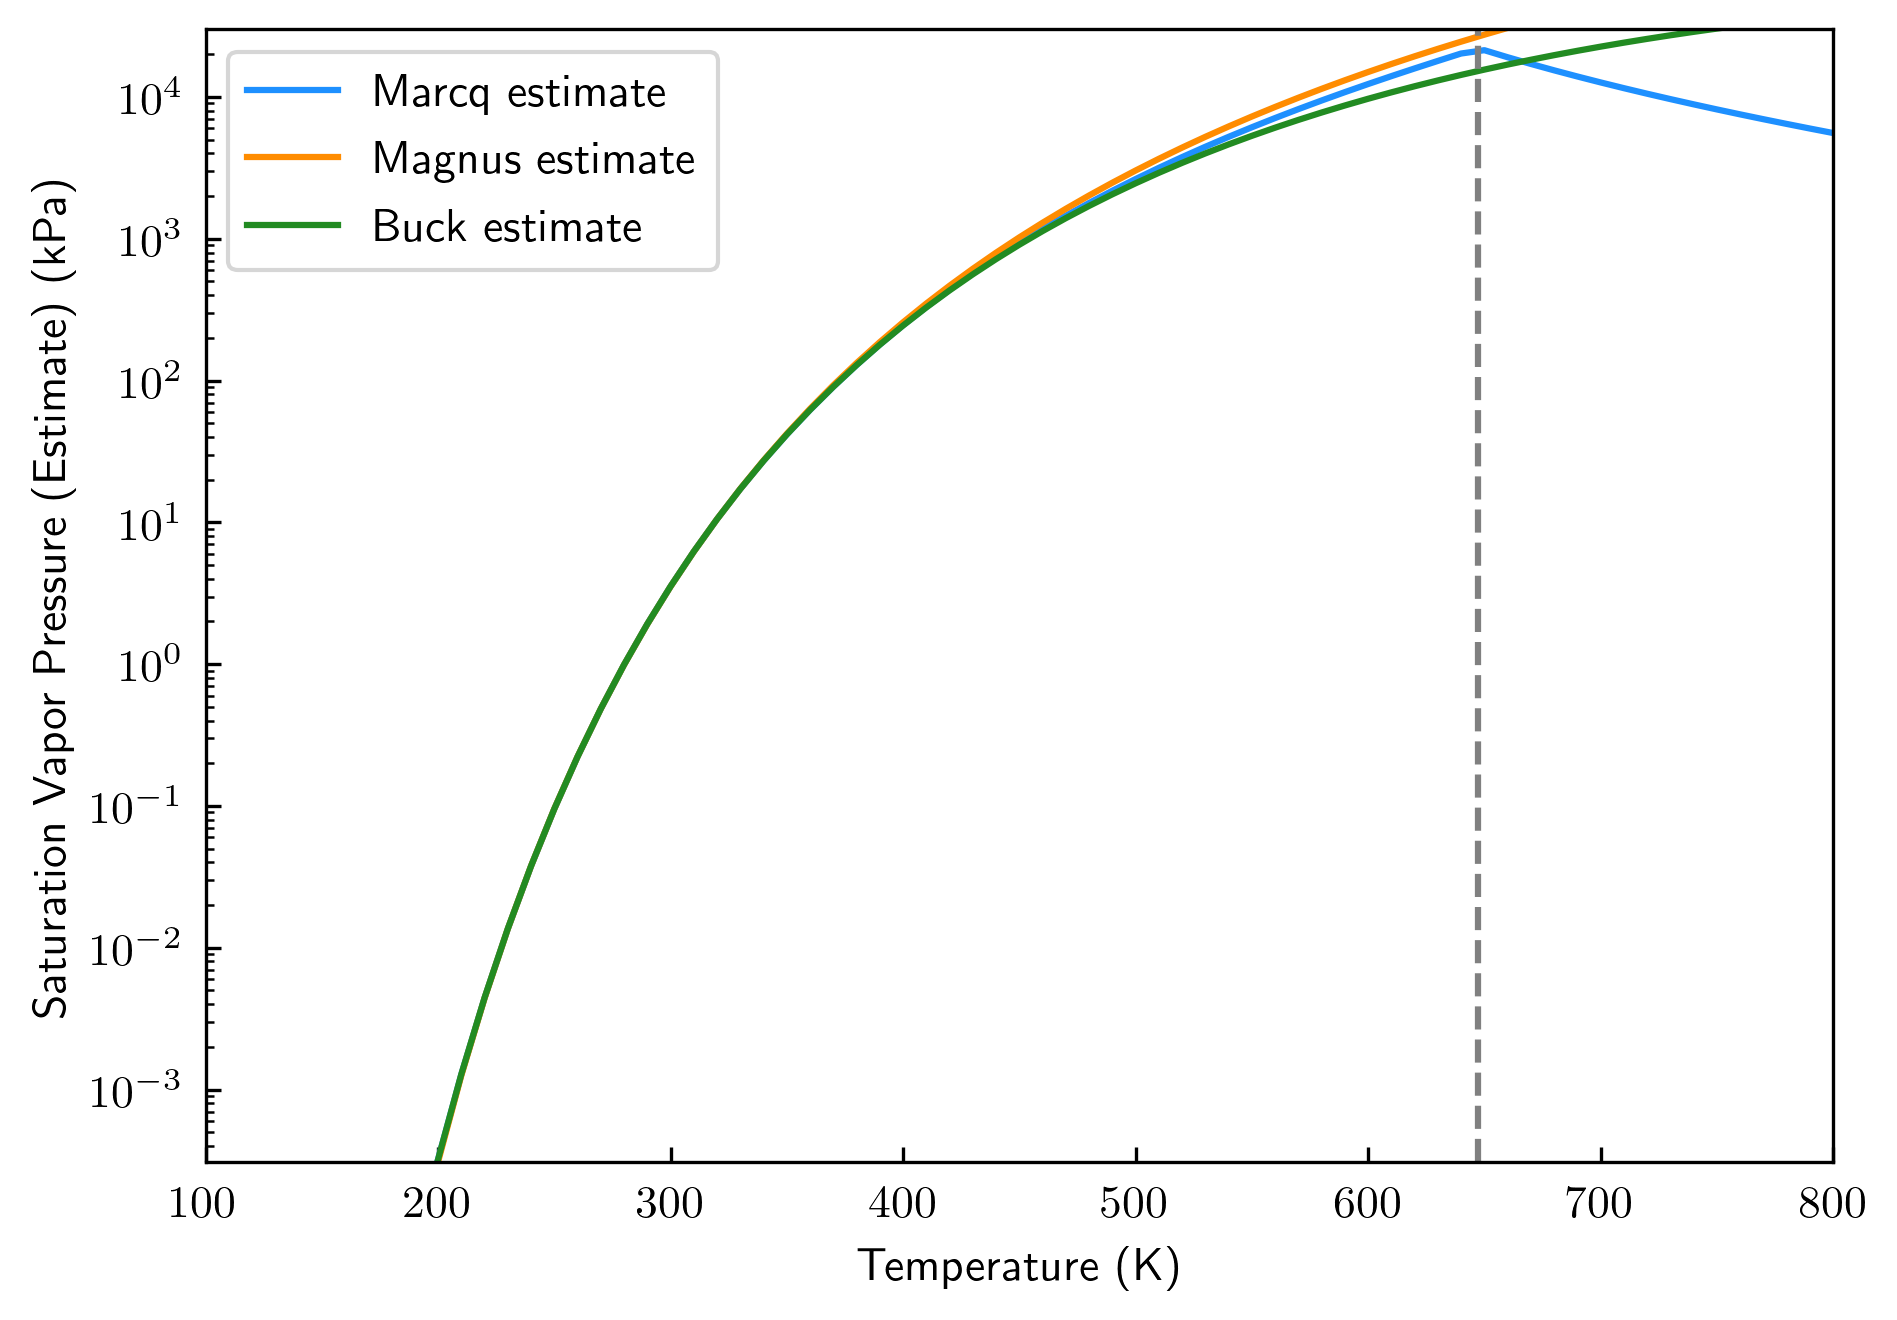

In [6]:
#Let's plot the water saturation vapor pressure curve as a function of temperature 

T_arr = np.arange(200,p1.Tsurf+10,10) #from 200 K to 1200 K

psat_try = []
psat_try2 = []
psat_try3 = []
for t in T_arr:
    psat_val = psat_est(t)
    psat_try.append(psat_val*1.0E3)
    psat_val2 = psat_est2(t)
    psat_try2.append(psat_val2/1.0E3)
    psat_val3 = psat_est3(t)
    psat_try3.append(psat_val3/1.0E3)

fig,ax=plt.subplots()
plt.plot(T_arr, psat_try, color='dodgerblue', label='Marcq estimate')
plt.plot(T_arr, psat_try2, color='darkorange', label='Magnus estimate')
plt.plot(T_arr, psat_try3, color='forestgreen', label='Buck estimate')

plt.axvline(x=647.25, ls='--', color='gray')
plt.xlabel('Temperature (K)')
plt.ylabel('Saturation Vapor Pressure (Estimate) (kPa)')
plt.legend()
plt.yscale('log')
plt.ylim(0,30000)
plt.xlim(100, 800)
plt.show()

## Dry Adiabat

In [7]:
#Following Catling & Kasting book:
def dry_ad_CK(T, P, Z, Planet):
    TT = T/1000.0
    if T<=1200.0:
        Cp_c = (24.99735 + (55.18696*TT) - (33.69137*(TT**2)) + (7.948387*(TT**3)) - (0.136638/(TT**2)))/M_c #J/kg K, NIST
    else:
        Cp_c = (58.16639 + (2.720074*TT) - (0.492289*(TT**2)) + (0.038844*(TT**3)) - (6.447293/(TT**2)))/M_c #J/kg K, NIST
   
    Cp_w = (30.09200 + (6.832514*TT) +(6.793435*(TT**2)) - (2.534480*(TT**3)) + (0.082138/(TT**2)))/M_w #J/kg K, NIST
    P_w = P*(Planet.Pw[0]/(Planet.Pc[0]+Planet.Pw[0]))
    rho_w=(M_w*P_w)/(R_c*T) 
    
    P_c = P*(Planet.Pc[0]/(Planet.Pc[0]+Planet.Pw[0]))
    rho_c=(M_c*P_c)/(R_c*T)
    dTdP = 1.0/((rho_w*Cp_w)+(rho_c*Cp_c))
    g = Planet.g0*(Planet.Rp/(Planet.Rp+Z))**2 
    dTdz = -g/(Cp_w+Cp_c)
    return dTdP, dTdz, rho_w, rho_c

#Following Kasting 1988, Marcq 2012, 2017:
def dry_ad(T, P, Planet):
    #Cp_c = (22.26 + (5.981E-2*T) - (3.501E-5*T**2) + (7.469E-9*T**3) )/M_c #from Marcq
    TT = T/1000.0
    if T<=1200.0:
        Cp_c = (24.99735 + (55.18696*TT) - (33.69137*(TT**2)) + (7.948387*(TT**3)) - (0.136638/(TT**2)))/M_c #J/kg K, NIST
    else:
        Cp_c = (58.16639 + (2.720074*TT) - (0.492289*(TT**2)) + (0.038844*(TT**3)) - (6.447293/(TT**2)))/M_c #J/kg K, NIST
   
    Cp_w = (30.09200 + (6.832514*TT) +(6.793435*(TT**2)) - (2.534480*(TT**3)) + (0.082138/(TT**2)))/M_w #J/kg K, NIST
    P_w = P*(Planet.Pw[0]/(Planet.Pc[0]+Planet.Pw[0]))
    rho_w=(M_w*P_w)/(R_c*T)
    
    P_c = P*(Planet.Pc[0]/(Planet.Pc[0]+Planet.Pw[0]))
    rho_c=(M_c*P_c)/(R_c*T)
    dTdP = 1.0/((rho_w*Cp_w)+(rho_c*Cp_c))
    return dTdP, rho_w, rho_c

#Both of these should give us the same results


## Moist Adiabat

In [8]:
#Compute entropy, only needed if following Marcq papers

def entrop_CO2(T): #From NIST
    #Gas phase
    TT = T/1000.0
    if T <=1200.0:   
        S = 24.99735*(np.log(TT)) + (55.18696*TT) - (33.69137*(TT**2)/2) + (7.948387*(TT**3)/3) - (-0.136638/(2*TT**2)) + 228.2431 #J/mol K 
    else:
        S = 58.16639*(np.log(TT)) + (2.720074*TT) - (0.492289*(TT**2)/2) + (0.038844*(TT**3)/3) - (-6.447293/(2*TT**2)) + 263.6125 #J/mol K 
    S = S/M_c #J/kg K 
    return S

def entrop_H2O_v(T): #From NIST
    #Vapor phase
    TT = T/1000.0
    S = 30.09200*np.log(TT) + (6.832514*TT) + (6.793435*(TT**2)/2) - (2.534480*(TT**3)/3) - (0.082139/(2*(TT**2))) + 223.3967 #J/mol K
    S = S/M_w #J/kg K
    return S
    
def entrop_H2O_c(T): #From NIST
    #Liquid phase (condensed)
    TT = T/1000.0
    S = -203.6060*(np.log(TT)) + (1523.290*TT) - (3196.413*(TT**2)/2) + (2474.455*(TT**3)/3) - (3.855326/(2*(TT**2))) - 488.7163 #J/mol K
    S = S/M_w #J/kg K
    return S


def entrop_s(T, M): #Marcq
    TT = T/100.0
    C = [19.730271018,20.9662681977,-0.483429455355,6.05743189245,22.56023885,-9.87532442,-4.3135538513,      
         0.458155781,-0.047754901883,0.0041238460633,-0.00027929052852,0.14481695261E-04,-0.56473658748E-06,     
         0.16200446E-07,-0.3303822796E-09, 0.451916067368E-11,-0.370734122708E-13,0.137546068238E-15]
    
    h = C[1]+C[0]*(1.0-np.log(TT))/TT
    for i in np.arange(2,18):
        h = h + (float(i+1)-6.0)*C[i]*TT**(float(i+1)-6.0)
    g = -((C[0]/TT) +C[1])*np.log(TT)
    for i in np.arange(2,18):
        g = g - C[i]*TT**(float(i+1)-6.0)
    s = h-g
    s = (R_c/M)*s #when we are calculating CO2 entropy, this should be specific gas constant for CO2 instead of water, right?
    return s

### Following Marcq papers

In [9]:
#Moist Adiabat Function, Following Marcq papers:

def moist_ad(T, P, Planet):
    TT = T/1000.0
    if T<=1200.0:
        Cp_c = (24.99735 + (55.18696*TT) - (33.69137*(TT**2)) + (7.948387*(TT**3)) - (0.136638/(TT**2)))/M_c #J/kg K, NIST
    else:
        Cp_c = (58.16639 + (2.720074*TT) - (0.492289*(TT**2)) + (0.038844*(TT**3)) - (6.447293/(TT**2)))/M_c #J/kg K, NIST
 
    dPsat = dPsat_est3(T)
    
    rho_w = (M_w*psat_est3(T))/(R_c*T)
    
    drho_w = (M_w*(T*dPsat - psat_est3(T)))/(R_c*(T**2))
    dlnrho_w = (T/rho_w)*drho_w #this is dlnrho_w/dlnT
    
    P_w = psat_est3(T)
    P_c = P-P_w
    rho_c = (M_c*P_c)/(R_c*T)
    
    a_w = rho_w/rho_c
    s_c = entrop_H2O_c(T) #entropy of water in liquid phase
    s_w = entrop_H2O_v(T) #entropy of water in vapor phase
    #ds_w = ((1.52329 + (3855.326/(T**3)) + (2.47445E-6*(T**2)) - (0.00319641*T) - (203.606/T))/M_w)*T
    ds_w = ((0.00683251 + (82139/(T**3)) - (2.53448E-9 * (T**2)) + (6.79343E-6*T) + (30.092/T))*T)/M_w
    
    #if T > 273.0: #hot
    #    s_c = entrop_s(T, M_c)*1.0E3 #
    #else: #cold 
    #    s_c = 2278.0*np.log(T/273.15)
    
    dlna_w = (((R_c/M_c)*dlnrho_w) - Cp_c + (R_c/M_c) - (a_w*T*ds_w))/(a_w*(s_w-s_c)+(R_c/M_c)) #Check! Currently this follows Marcq
    
    dTdP = 1.0/(dPsat + (rho_c * (R_c/M_c)*(1.0+dlnrho_w-dlna_w)))
    return dTdP, a_w, dlna_w


### Following Pierrehumbert Book

In [118]:
def moist_ad_RP(T, P, Z, Planet):
    TT = T/1000.0
    if T<=1200.0:
        Cp_a = (24.99735 + (55.18696*TT) - (33.69137*(TT**2)) + (7.948387*(TT**3)) - (0.136638/(TT**2)))/M_c #J/kg K, NIST
    else:
        Cp_a = (58.16639 + (2.720074*TT) - (0.492289*(TT**2)) + (0.038844*(TT**3)) - (6.447293/(TT**2)))/M_c #J/kg K, NIST
    #Cp_w = (-203.6060 + (1523.290*TT) - (3196.413*(TT**2)) - (2474.455*(TT**3)) + (3.855326/(TT**2))) #Water in liquid phase
    Cp_w = (30.09200 + (6.832514*TT) + (6.793435*(TT**2)) - (2.534480*(TT**3)) + (0.082139/(TT**2)))/M_w #Water in vapor phase

    g = Planet.g0*(Planet.Rp/(Planet.Rp+Z))**2 
    R_cw = R_u/M_w 
    R_a = R_u/M_c 
    
    P_w = psat_est3(T) #water's partial pressure, just the saturation vapor pressure at that temperature
    P_a = P-P_w #CO2's partial pressure
    #dPsat = dPsat_est3(T) #We can calculate this analytically, or use Clausius Clapeyron if we assume L is constant
    
    eta = M_w/M_c #water/CO2
    r_sat = (eta*P_w)/P_a
    
    #L = (dPsat * R_cw * (T**2))/(P_w) #Using Clausius Clapeyron to derive L (dPsat = L/RT^2 * Psat)
    L = 2389.5E3 #J/kg, assuming it's constant
    
    dPsat = (L/(R_a*(T**2)))*P_w #using Clausius Clapeyron
    #Setting up the top and bottom fractions in eq. 2.33:
    top = 1.0 + ((L/(R_a*T))*r_sat)
    bottom = 1.0 + ((Cp_w/Cp_a) + (((L/(R_cw*T))-1.0)*(L/(Cp_a*T))))*r_sat

    dlnTdlnP_a = (R_a/Cp_a) * (top/bottom) #eq. 2.33 
    
    #Converting from dlnTdlnP_c (where c stands for CO2, the non-condensable substance to dTdP, with P being total pressure
    dTdPa = (T/P_a)*dlnTdlnP_a
    dPadP = 1.0/(1.0+(dPsat/dTdPa))
    dlnTdlnP = dlnTdlnP_a * (P/P_a) * dPadP
    dTdP = (T/P)*dlnTdlnP
    
    rho_w = (M_w*P_w)/(R_u*T) #water
    rho_c = (M_c*P_a)/(R_u*T) #CO2
    dTdz = -(g * (rho_w+rho_c))*dTdP
    
    return dTdP, dTdz, rho_w, rho_c


In [11]:
#Slightly Simplified Version
def moist_ad_RP_simp(T, P, Z, Planet):
    TT = T/1000.0
    if T<=1200.0:
        Cp_a = (24.99735 + (55.18696*TT) - (33.69137*(TT**2)) + (7.948387*(TT**3)) - (0.136638/(TT**2)))/M_c #J/kg K, NIST
    else:
        Cp_a = (58.16639 + (2.720074*TT) - (0.492289*(TT**2)) + (0.038844*(TT**3)) - (6.447293/(TT**2)))/M_c #J/kg K, NIST
    #Cp_w = (-203.6060 + (1523.290*TT) - (3196.413*(TT**2)) - (2474.455*(TT**3)) + (3.855326/(TT**2))) #Water in liquid phase
    Cp_w = (30.09200 + (6.832514*TT) + (6.793435*(TT**2)) - (2.534480*(TT**3)) + (0.082139/(TT**2)))/M_w #Water in vapor phase

    g = Planet.g0*(Planet.Rp/(Planet.Rp+Z))**2 
    R_cw = R_u/M_w
    R_a = R_u/M_c
    
    P_w = psat_est3(T)
    P_a = P-P_w
    dPsat = dPsat_est3(T)
    
    eta = M_w/M_c #H2O/CO2
    r_sat = (eta*P_w)/P_a
    L = (dPsat * R_cw * (T**2))/(P_w)
    
    top = 1.0 + (dPsat*T/P_a)
    bottom = 1.0 + ((Cp_w/Cp_a) + ((dPsat*(T/P_w))-1)*(dPsat*R_cw*T/(P_w*Cp_a)))*(M_w/M_c)*(P_w/P_a)

    dlnTdlnP_a = (R_a/Cp_a) * (top/bottom)
    dTdPa = (T/P_a)*dlnTdlnP_a
    dPadP = 1/(1+(dPsat/dTdPa))
    dlnTdlnP = dlnTdlnP_a * (P/P_a) * dPadP
    dTdP = (T/P)*dlnTdlnP
    
    rho_w = (M_w*P_w)/(R_c*T) #H2O
    rho_c = (M_c*P_a)/(R_c*T) #CO2
    dTdz = -(g * (rho_w+rho_c))*dTdP
    
    return dTdP, dTdz, rho_w, rho_c

## Isothermal Region

In [12]:
#Mesosphere is the purely radiative layer (constant T):

Ttop = 200.0 #K, following Kasting 1988

## Main Loop

In [13]:
#Main loop to compute thermal profile, with adiabats following Marcq papers
def thermprof_Marcq(Planet):
    
    Planet.a_w[0] = Planet.rho_w[0]/Planet.rho_c[0]

    for i in np.arange(1, Planet.Nz):
        if Planet.Pw[i-1] < psat_est3(Planet.T_arr[i-1]):
            dTdP_d_arr = dry_ad(Planet.T_arr[i-1], np.exp(Planet.lnPtab[i-1]), Planet)
            dTdP_d = dTdP_d_arr[0]
            Planet.rho_w[i] = dTdP_d_arr[1]
            Planet.rho_c[i] = dTdP_d_arr[2]
            print('dry ad:', dTdP_d)
            Planet.a_w[i] = Planet.rho_w[i]/Planet.rho_c[i]
            Planet.T_arr[i] = Planet.T_arr[i-1]-dTdP_d*np.exp(Planet.lnPtab[i])*Planet.dlnPtab[i]
            if Planet.T_arr[i]<=Ttop:
                Planet.track_isotherm[i]=i
                flag=2 #In isothermal regime
                Planet.T_arr[i]=Ttop
                dTdP_d =0.0
            Planet.Pw[i] = np.exp(Planet.lnPtab[i])*(Planet.Pw[0]/(Planet.Pc[0]+Planet.Pw[0]))
            Planet.Pc[i] = np.exp(Planet.lnPtab[i])*(Planet.Pc[0]/(Planet.Pc[0]+Planet.Pw[0]))   
            print('Water Pressure:', Planet.Pw[i-1])
            print('Water Saturation Vapor Pressure:', psat_est3(Planet.T_arr[i-1]))
            Planet.rho_c[i] = (M_c*Planet.Pc[i])/(R_c*Planet.T_arr[i])
            Planet.rho_w[i] = (M_w*Planet.Pw[i])/(R_c*Planet.T_arr[i]) #assuming ideal gas 
            
        else:
            
            flag=1
            Planet.track_moist[i] =i
            print(Planet.track_moist[i])
            Moist_Start=i
            break
            
    for i in np.arange(Moist_Start, Planet.Nz):
        print(i)
        Planet.Pw[i-1] = psat_est3(Planet.T_arr[i-1]) 
        dTdP_m_arr = moist_ad(Planet.T_arr[i-1], np.exp(Planet.lnPtab[i-1]), Planet)
        dTdP_m = dTdP_m_arr[0]
        print('moist ad:', dTdP_m)
        Planet.a_w[i] = dTdP_m_arr[1]
        dlna_w = dTdP_m_arr[2]
        Planet.T_arr[i] = Planet.T_arr[i-1]-dTdP_m*np.exp(Planet.lnPtab[i])*Planet.dlnPtab[i]
        if Planet.T_arr[i]<=Ttop:
            Planet.track_isotherm[i]=i
            flag=2 #In isothermal regime
            Planet.T_arr[i]=Ttop
            dTdP_m = 0.0
            Isotherm_Start = i
            break
        Planet.a_w[i] = np.exp(np.log(Planet.a_w[i])-dlna_w*dTdP_m*np.exp(Planet.lnPtab[i])*Planet.dlnPtab[i]/Planet.T_arr[i])
        if Planet.a_w[i] < 1.0E-9:
            Planet.a_w[i] = 1.0E-9
            Planet.T_arr[i]=Ttop
            Planet.track_isotherm[i]=i
            flag=2
            dTdP_m = 0.0
        Planet.Pw[i] = psat_est3(Planet.T_arr[i])
        Planet.Pc[i] = np.exp(Planet.lnPtab[i]) - Planet.Pw[i]
        print('Temperature:', Planet.T_arr[i])
        Planet.rho_c[i] = (M_c*Planet.Pc[i])/(R_c*Planet.T_arr[i])
        Planet.rho_w[i] = (M_w*Planet.Pw[i])/(R_c*Planet.T_arr[i]) #assuming ideal gas

    for i in np.arange(Isotherm_Start, Planet.Nz): 
        Planet.T_arr[i] = Ttop
        Planet.a_w[i] = Planet.a_w[i-1]
        Planet.Pc[i]=np.exp(Planet.lnPtab[i])/(1.0+Planet.a_w[i]*M_c/M_w)
        Planet.Pw[i]=np.exp(Planet.lnPtab[i])/(1.0+Planet.a_w[i]*M_c/M_w)*Planet.a_w[i]*M_c/M_w

        print('Temperature:', Planet.T_arr[i])
        Planet.rho_c[i] = (M_c*Planet.Pc[i])/(R_c*Planet.T_arr[i])
        Planet.rho_w[i] = (M_w*Planet.Pw[i])/(R_c*Planet.T_arr[i]) #assuming ideal gas
    
        

    return Planet


In [119]:
#Main loop to compute thermal profile, with dry adiabat following Catling & Kasting book and moist adiabat following Pierrehumbert

def thermprof(Planet):
    
    Planet.a_w[0] = Planet.rho_w[0]/Planet.rho_c[0]
    Planet.Z[0] = 0.0
    for i in np.arange(1, Planet.Nz):
        if Planet.Pw[i-1] < psat_est3(Planet.T_arr[i-1]):
            dTdP_d_arr = dry_ad_CK(Planet.T_arr[i-1], np.exp(Planet.lnPtab[i-1]), Planet.Z[i-1], Planet)
            dTdP_d = dTdP_d_arr[0]
            dTdz_d = dTdP_d_arr[1]
            Planet.rho_w[i] = dTdP_d_arr[2]
            Planet.rho_c[i] = dTdP_d_arr[3]
            print('dry ad:', dTdP_d)
            Planet.a_w[i] = Planet.rho_w[i]/Planet.rho_c[i]
            Planet.T_arr[i] = Planet.T_arr[i-1]-dTdP_d*np.exp(Planet.lnPtab[i])*Planet.dlnPtab[i]
            if Planet.T_arr[i]<=Ttop:
                Planet.track_isotherm[i]=i
                flag=2 #In isothermal regime
                Planet.T_arr[i]=Ttop
                dTdP_d =0.0
            Planet.Pw[i] = np.exp(Planet.lnPtab[i])*(Planet.Pw[0]/(Planet.Pc[0]+Planet.Pw[0]))
            Planet.Pc[i] = np.exp(Planet.lnPtab[i])*(Planet.Pc[0]/(Planet.Pc[0]+Planet.Pw[0]))   
            print('Water Pressure:', Planet.Pw[i-1])
            print('Water Saturation Vapor Pressure:', psat_est3(Planet.T_arr[i-1]))
            Planet.rho_c[i] = (M_c*Planet.Pc[i])/(R_c*Planet.T_arr[i])
            Planet.rho_w[i] = (M_w*Planet.Pw[i])/(R_c*Planet.T_arr[i]) #assuming ideal gas
            
            Planet.Z[i] = Planet.Z[i-1] + (1/dTdz_d)*Planet.T_arr[i]
            
        else:
            flag=1
            Planet.track_moist[i] =i
            print(Planet.track_moist[i])
            Moist_Start=i
            break
            
    for i in np.arange(Moist_Start, Planet.Nz):
        print(i)
        Planet.Pw[i-1] = psat_est3(Planet.T_arr[i-1]) 
        dTdP_m_arr = moist_ad_RP(Planet.T_arr[i-1], np.exp(Planet.lnPtab[i-1]), Planet.Z[i-1], Planet)
        dTdP_m = dTdP_m_arr[0]
        dTdz_m = dTdP_m_arr[1]
        print('moist ad:', dTdP_m)
        Planet.rho_w[i] = dTdP_m_arr[2]
        Planet.rho_c[i] = dTdP_m_arr[3]
        Planet.a_w[i] = Planet.rho_w[i]/Planet.rho_c[i]
        if i == Planet.Nz-1:
            Planet.T_arr[i] = Planet.T_arr[i-1]-dTdP_m*np.exp(Planet.lnPtab[i])*Planet.dlnPtab[i-1]
            if Planet.T_arr[i]<=Ttop:
                Planet.track_isotherm[i]=i
                flag=2 #In isothermal regime
                Planet.T_arr[i]=Ttop
                dTdP_m = 0.0
                Isotherm_Start = i
        else:
            Planet.T_arr[i] = Planet.T_arr[i-1]-dTdP_m*np.exp(Planet.lnPtab[i])*Planet.dlnPtab[i]
            if Planet.T_arr[i]<=Ttop:
                Planet.track_isotherm[i]=i
                flag=2 #In isothermal regime
                #print('Now in Isothermal Regime, Layer is:', i)
                Planet.T_arr[i]=Ttop
                dTdP_m = 0.0
        Planet.Pw[i] = psat_est3(Planet.T_arr[i])
        Planet.Pc[i] = np.exp(Planet.lnPtab[i]) - Planet.Pw[i]
        print('Temperature:', Planet.T_arr[i])
        Planet.rho_c[i] = (M_c*Planet.Pc[i])/(R_c*Planet.T_arr[i])
        Planet.rho_w[i] = (M_w*Planet.Pw[i])/(R_c*Planet.T_arr[i]) #assuming ideal gas
        Planet.Z[i] = Planet.Z[i-1] + (1/dTdz_m)*Planet.T_arr[i]
    
           
    for i in np.arange(Isotherm_Start, Planet.Nz): 
        Planet.T_arr[i] = Ttop
        Planet.a_w[i] = Planet.a_w[i-1]
        Planet.Pc[i]=np.exp(Planet.lnPtab[i])/(1.0+Planet.a_w[i]*M_c/M_w)
        Planet.Pw[i]=np.exp(Planet.lnPtab[i])/(1.0+Planet.a_w[i]*M_c/M_w)*Planet.a_w[i]*M_c/M_w
        print('Temperature:', Planet.T_arr[i])
        Planet.rho_c[i] = (M_c*Planet.Pc[i])/(R_c*Planet.T_arr[i])
        Planet.rho_w[i] = (M_w*Planet.Pw[i])/(R_c*Planet.T_arr[i]) #assuming ideal gas
        Planet.Z[i] = Planet.Z[i-1] 



        

    return Planet

## Set Surface Conditions and Run Models

In [120]:
def surf_conds(planet):
    planet.Pw[0]=planet.Ps_w
    planet.Pc[0]=planet.Ps_c
    planet.T_arr[0]=planet.Tsurf
    planet.rho_c[0]=(M_c*planet.Pc[0])/(R_c*planet.T_arr[0])
    planet.rho_w[0]=(M_w*planet.Pw[0])/(R_c*planet.T_arr[0])
    
    Pmin = 0.01
    planet.lnPtab[0]=np.log(planet.Pw[0]+planet.Pc[0])
    
    lnPtab_minmax = np.linspace(np.log(Pmin), planet.lnPtab[0], planet.Nz) #evenly spaced from Pmin to Psurface
    lnPtab_arr = lnPtab_minmax[::-1] #reverse so it goes from Psurface to Pmin
    
    planet.lnPtab = lnPtab_arr

    for i in np.arange(1, planet.Nz):
        planet.dlnPtab[i-1] = planet.lnPtab[i-1] - planet.lnPtab[i]
    
    return planet 

In [121]:
#Make Planet:
p_1400 = Planet_Bounds(1400.0, 200.0, 300.0E5, 100.0E5, 9.8, 6.37E6, 500, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
p_1400 = surf_conds(p_1400)
P_1400 = thermprof(p_1400)

dry ad: 5.935514459942842e-06
Water Pressure: 30000000.0
Water Saturation Vapor Pressure: 49161515.01216527
dry ad: 6.172212223324171e-06
Water Pressure: 28699785.411726296
Water Saturation Vapor Pressure: 49954625.78711206
dry ad: 6.418324330406881e-06
Water Pressure: 27455922.75597123
Water Saturation Vapor Pressure: 50736318.83298713
dry ad: 6.6742218762148505e-06
Water Pressure: 26265969.71257689
Water Saturation Vapor Pressure: 51505553.11715425
dry ad: 6.9402904200019234e-06
Water Pressure: 25127589.812728606
Water Saturation Vapor Pressure: 52261281.50546062
dry ad: 7.2169305431495486e-06
Water Pressure: 24038547.851306338
Water Saturation Vapor Pressure: 53002452.68575429
dry ad: 7.504558428475685e-06
Water Pressure: 22996705.49806677
Water Saturation Vapor Pressure: 53728013.15985886
dry ad: 7.803606461782153e-06
Water Pressure: 22000017.099039406
Water Saturation Vapor Pressure: 54436909.30040934
dry ad: 8.114523856501374e-06
Water Pressure: 21046525.659891322
Water Saturatio

/Users/maggiethompson/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in double_scalars
/Users/maggiethompson/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in double_scalars


302
moist ad: 7.73753812117073e-10
Temperature: 329.8045826624323
303
moist ad: 7.734868064630065e-10
Temperature: 329.80458266040705
304
moist ad: 7.732314982990078e-10
Temperature: 329.80458265847017
305
moist ad: 7.729873699485666e-10
Temperature: 329.80458265661787
306
moist ad: 7.727539270881562e-10
Temperature: 329.80458265484634
307
moist ad: 7.725306976562545e-10
Temperature: 329.8045826531521
308
moist ad: 7.72317230816417e-10
Temperature: 329.80458265153175
309
moist ad: 7.721130959716008e-10
Temperature: 329.804582649982
310
moist ad: 7.719178818268276e-10
Temperature: 329.80458264849983
311
moist ad: 7.71731195497715e-10
Temperature: 329.8045826470822
312
moist ad: 7.715526616623768e-10
Temperature: 329.8045826457264
313
moist ad: 7.713819217543738e-10
Temperature: 329.80458264442956
314
moist ad: 7.71218633194663e-10
Temperature: 329.80458264318924
315
moist ad: 7.710624686603652e-10
Temperature: 329.8045826420029
316
moist ad: 7.70913115388585e-10
Temperature: 329.8045826

UnboundLocalError: local variable 'Isotherm_Start' referenced before assignment

In [17]:
#Make Planet:
p_1400_M = Planet_Bounds(1400.0, 200.0, 300.0E5, 100.0E5, 9.8, 6.37E6, 500, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
p_1400_M = surf_conds(p_1400_M)
P_1400_M = thermprof_Marcq(p_1400_M)

dry ad: 5.935514459942842e-06
Water Pressure: 30000000.0
Water Saturation Vapor Pressure: 49161515.01216527
dry ad: 6.172212223324171e-06
Water Pressure: 28699785.411726296
Water Saturation Vapor Pressure: 49954625.78711206
dry ad: 6.418324330406881e-06
Water Pressure: 27455922.75597123
Water Saturation Vapor Pressure: 50736318.83298713
dry ad: 6.6742218762148505e-06
Water Pressure: 26265969.71257689
Water Saturation Vapor Pressure: 51505553.11715425
dry ad: 6.9402904200019234e-06
Water Pressure: 25127589.812728606
Water Saturation Vapor Pressure: 52261281.50546062
dry ad: 7.2169305431495486e-06
Water Pressure: 24038547.851306338
Water Saturation Vapor Pressure: 53002452.68575429
dry ad: 7.504558428475685e-06
Water Pressure: 22996705.49806677
Water Saturation Vapor Pressure: 53728013.15985886
dry ad: 7.803606461782153e-06
Water Pressure: 22000017.099039406
Water Saturation Vapor Pressure: 54436909.30040934
dry ad: 8.114523856501374e-06
Water Pressure: 21046525.659891322
Water Saturatio

/Users/maggiethompson/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in log



247
moist ad: 0.019855801805650476
Temperature: 275.30536816423864
248
moist ad: 0.020650351347292845
Temperature: 274.68692341481625
249
moist ad: 0.021477017360712298
Temperature: 274.07159804053026
250
moist ad: 0.022337108589948088
Temperature: 273.4593671948163
251
moist ad: 0.02323198747213054
Temperature: 272.85020630724995
252
moist ad: 0.024163072353195893
Temperature: 272.24409107957354
253
moist ad: 0.025131839795478592
Temperature: 271.64099748179086
254
moist ad: 0.026139826981013994
Temperature: 271.0409017483288
255
moist ad: 0.027188634214538838
Temperature: 270.4437803742656
256
moist ad: 0.02827992753035334
Temperature: 269.849610111624
257
moist ad: 0.029415441407363248
Temperature: 269.2583679657285
258
moist ad: 0.030596981596820085
Temperature: 268.670031191626
259
moist ad: 0.03182642806745782
Temperature: 268.08457729056784
260
moist ad: 0.033105738072919035
Temperature: 267.5019840065533
261
moist ad: 0.03443694934657466
Temperature: 266.92222932293197
262
moi

Temperature: 203.14330767810478
412
moist ad: 14.97117906082773
Temperature: 202.8300929217554
413
moist ad: 15.595503165814506
Temperature: 202.51795754326716
414
moist ad: 16.245967697438964
Temperature: 202.20689581196007
415
moist ad: 16.923671080162862
Temperature: 201.896902038758
416
moist ad: 17.62975804305726
Temperature: 201.58797057580236
417
moist ad: 18.365421577486277
Temperature: 201.28009581607017
418
moist ad: 19.131904977777605
Temperature: 200.97327219299646
419
moist ad: 19.93050396840816
Temperature: 200.6674941801009
420
moist ad: 20.76256892137858
Temperature: 200.36275629061873
421
moist ad: 21.629507167613205
Temperature: 200.05905307713584
422
moist ad: 22.532785406379773
Temperature: 200.0
Temperature: 200.0
Temperature: 200.0
Temperature: 200.0
Temperature: 200.0
Temperature: 200.0
Temperature: 200.0
Temperature: 200.0
Temperature: 200.0
Temperature: 200.0
Temperature: 200.0
Temperature: 200.0
Temperature: 200.0
Temperature: 200.0
Temperature: 200.0
Temperat

## Plot Results

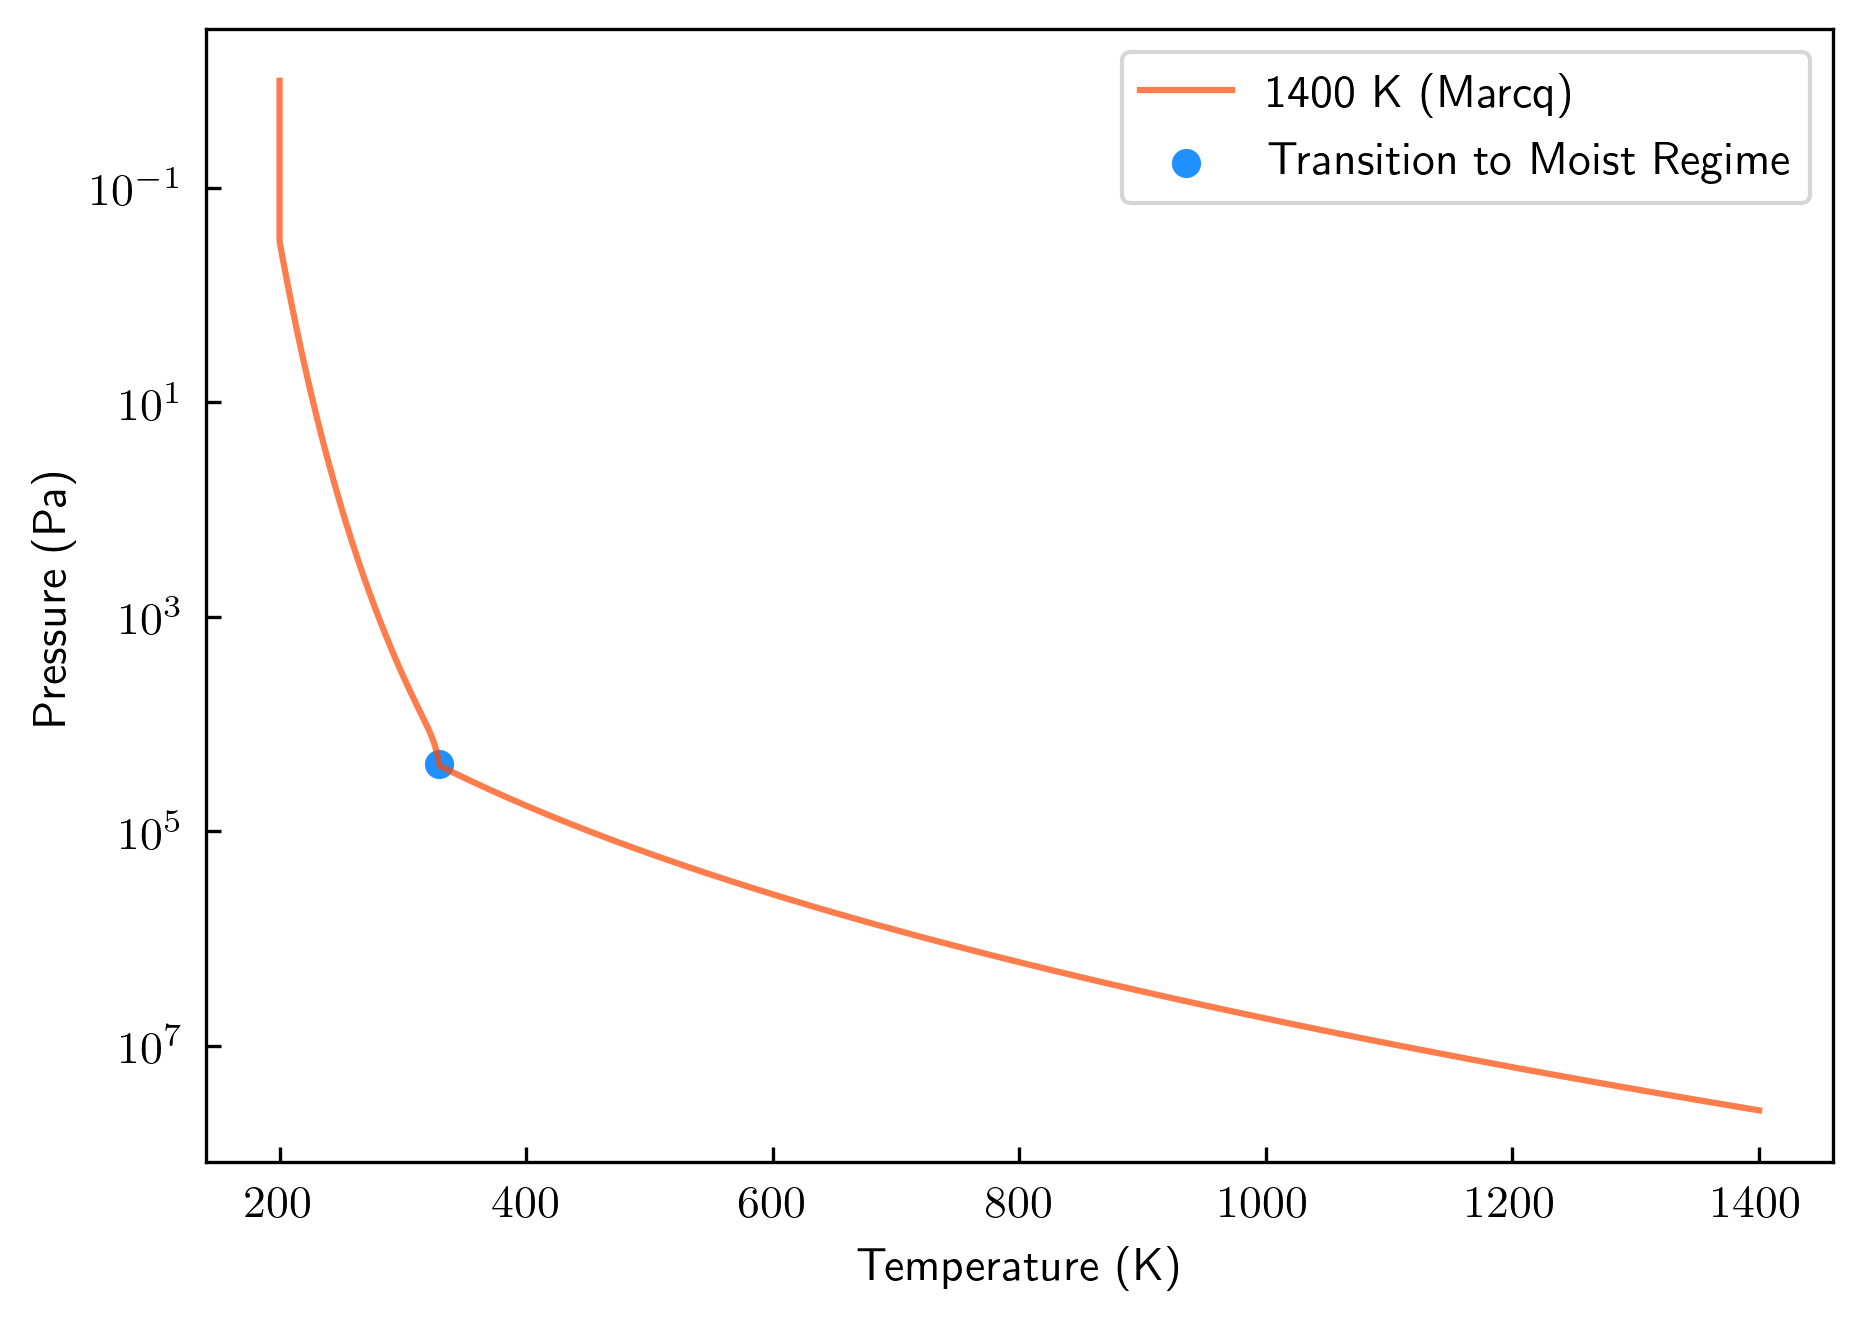

In [114]:
fig,ax=plt.subplots()
plt.plot(P_1400_M.T_arr, np.exp(P_1400_M.lnPtab), alpha=0.7, color='orangered', label='1400 K (Marcq)')
#plt.plot(P_1400.T_arr, np.exp(P_1400.lnPtab), alpha=0.7, color='forestgreen', label='1400 K (RP)')

plt.scatter(P_1400_M.T_arr[np.min(P_1400_M.track_moist)], np.exp(P_1400_M.lnPtab[np.min(P_1400_M.track_moist)]), color='dodgerblue', label='Transition to Moist Regime')
#plt.scatter(P_1400.T_arr[np.min(P_1400.track_moist)], np.exp(P_1400.lnPtab[np.min(P_1400.track_moist)]), color='orange', label='Transition to Moist Regime')

plt.xlabel('Temperature (K)')
plt.ylabel('Pressure (Pa)')
plt.gca().invert_yaxis()
plt.yscale('log')
plt.legend()
#plt.savefig('TPProfs.jpg', dpi=1000)
plt.show()

## ODE with Event-Finding Approach

In [208]:
# Dry and Moist Functions:

def dry_ad_odetry(P, T, Pw_i, Pc_i):
    TT = T/1000.0
    if T<=1200.0:
        Cp_c = (24.99735 + (55.18696*TT) - (33.69137*(TT**2)) + (7.948387*(TT**3)) - (0.136638/(TT**2)))/M_c #J/kg K, NIST, vapor phase
    else:
        Cp_c = (58.16639 + (2.720074*TT) - (0.492289*(TT**2)) + (0.038844*(TT**3)) - (6.447293/(TT**2)))/M_c #J/kg K, NIST, vapor phase
   
    Cp_w = (30.09200 + (6.832514*TT) +(6.793435*(TT**2)) - (2.534480*(TT**3)) + (0.082138/(TT**2)))/M_w #J/kg K, NIST, vapor phase
    
    P_w = P*(Pw_i/(Pc_i+Pw_i))
    rho_w=(M_w*P_w)/(R_c*T) 
    
    P_c = P*(Pc_i/(Pc_i+Pw_i))
    rho_c=(M_c*P_c)/(R_c*T)
    
    dTdP = 1.0/((rho_w*Cp_w)+(rho_c*Cp_c))
    print('dTdP:', dTdP)
    #print('T:', T)
    #print('P:', P)
    #g = Planet.g0*(Planet.Rp/(Planet.Rp+Z))**2 
    #dTdz = -g/(Cp_w+Cp_c)
    return dTdP

def moist_ad_odetry(T, P):
    TT = T/1000.0
    if T<=1200.0:
        Cp_c = (24.99735 + (55.18696*TT) - (33.69137*(TT**2)) + (7.948387*(TT**3)) - (0.136638/(TT**2)))/M_c #J/kg K, NIST
    else:
        Cp_c = (58.16639 + (2.720074*TT) - (0.492289*(TT**2)) + (0.038844*(TT**3)) - (6.447293/(TT**2)))/M_c #J/kg K, NIST
 
    dPsat = dPsat_est3(T)
    
    rho_w = (M_w*psat_est3(T))/(R_c*T)
    
    drho_w = (M_w*(T*dPsat - psat_est3(T)))/(R_c*(T**2))
    dlnrho_w = (T/rho_w)*drho_w #this is dlnrho_w/dlnT
    
    P_w = psat_est3(T)
    P_c = P-P_w
    rho_c = (M_c*P_c)/(R_c*T)
    
    a_w = rho_w/rho_c
    s_c = entrop_H2O_c(T) #entropy of water in liquid phase
    s_w = entrop_H2O_v(T) #entropy of water in vapor phase
    #ds_w = ((1.52329 + (3855.326/(T**3)) + (2.47445E-6*(T**2)) - (0.00319641*T) - (203.606/T))/M_w)*T
    ds_w = ((0.00683251 + (82139/(T**3)) - (2.53448E-9 * (T**2)) + (6.79343E-6*T) + (30.092/T))*T)/M_w
    
    #if T > 273.0: #hot
    #    s_c = entrop_s(T, M_c)*1.0E3 #
    #else: #cold 
    #    s_c = 2278.0*np.log(T/273.15)
    
    dlna_w = (((R_c/M_c)*dlnrho_w) - Cp_c + (R_c/M_c) - (a_w*T*ds_w))/(a_w*(s_w-s_c)+(R_c/M_c)) #Check! Currently this follows Marcq
    
    dTdP = 1.0/(dPsat + (rho_c * (R_c/M_c)*(1.0+dlnrho_w-dlna_w)))
    print('dTdP:', dTdP)
    return dTdP





In [201]:
def moist_ad_RP_odetry(T, P):
    TT = T/1000.0
    if T<=1200.0:
        Cp_a = (24.99735 + (55.18696*TT) - (33.69137*(TT**2)) + (7.948387*(TT**3)) - (0.136638/(TT**2)))/M_c #J/kg K, NIST
    else:
        Cp_a = (58.16639 + (2.720074*TT) - (0.492289*(TT**2)) + (0.038844*(TT**3)) - (6.447293/(TT**2)))/M_c #J/kg K, NIST
    #Cp_w = (-203.6060 + (1523.290*TT) - (3196.413*(TT**2)) - (2474.455*(TT**3)) + (3.855326/(TT**2))) #Water in liquid phase
    Cp_w = (30.09200 + (6.832514*TT) + (6.793435*(TT**2)) - (2.534480*(TT**3)) + (0.082139/(TT**2)))/M_w #Water in vapor phase

    #g = Planet.g0*(Planet.Rp/(Planet.Rp+Z))**2 
    R_cw = R_u/M_w 
    R_a = R_u/M_c 
    
    P_w = psat_est3(T) #water's partial pressure, just the saturation vapor pressure at that temperature
    P_a = P-P_w #CO2's partial pressure
    #dPsat = dPsat_est3(T) #We can calculate this analytically, or use Clausius Clapeyron if we assume L is constant
    
    eta = M_w/M_c #water/CO2
    r_sat = (eta*P_w)/P_a
    
    #L = (dPsat * R_cw * (T**2))/(P_w) #Using Clausius Clapeyron to derive L (dPsat = L/RT^2 * Psat)
    L = 2389.5E3 #J/kg, assuming it's constant
    
    dPsat = (L/(R_a*(T**2)))*P_w #using Clausius Clapeyron
    #Setting up the top and bottom fractions in eq. 2.33:
    top = 1.0 + ((L/(R_a*T))*r_sat)
    bottom = 1.0 + ((Cp_w/Cp_a) + (((L/(R_cw*T))-1.0)*(L/(Cp_a*T))))*r_sat

    dlnTdlnP_a = (R_a/Cp_a) * (top/bottom) #eq. 2.33 
    
    #Converting from dlnTdlnP_c (where c stands for CO2, the non-condensable substance to dTdP, with P being total pressure
    dTdPa = (T/P_a)*dlnTdlnP_a
    dPadP = 1.0/(1.0+(dPsat/dTdPa))
    dlnTdlnP = dlnTdlnP_a * (P/P_a) * dPadP
    dTdP = (T/P)*dlnTdlnP
    
    rho_w = (M_w*P_w)/(R_u*T) #water
    rho_c = (M_c*P_a)/(R_u*T) #CO2
    #dTdz = -(g * (rho_w+rho_c))*dTdP
    print(dTdP)
    return dTdP


In [204]:
planet_try = Planet_Bounds(1400.0, 200.0, 300.0E5, 100.0E5, 9.8, 6.37E6, 500, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
planet_try = surf_conds(planet_try)

P_eval_log = np.linspace(np.min((planet_try.lnPtab)), np.max((planet_try.lnPtab))-0.00001, 100)
P_eval = np.exp(P_eval_log)

#First event: P_w = Psat
def event_moist(P, T, Pw_i, Pc_i):
    P_w = P*(Pw_i/(Pc_i+Pw_i))
    event=[]
    for i in T:
        if i > 0:
            if P_w >= psat_est3(i):
                event = 0
    return event

event_moist.terminal = True
sol_try = solve_ivp(dry_ad_odetry, [planet_try.Ps_w+planet_try.Ps_c, np.min(np.exp(planet_try.lnPtab))], [planet_try.Tsurf], t_eval = P_eval[::-1], events = [event_moist], args=(planet_try.Ps_w, planet_try.Ps_c,))

P_sol = sol_try.t
T_sol = sol_try.y[0]

print(sol_try)

dTdP: [5.93551446e-06]
dTdP: [5.93551446e-06]
dTdP: [5.93551446e-06]
dTdP: [5.93551446e-06]
dTdP: [5.93551446e-06]
dTdP: [5.93551446e-06]
dTdP: [5.93551446e-06]
dTdP: [5.93551446e-06]
dTdP: [5.93551446e-06]
dTdP: [5.93551446e-06]
dTdP: [5.93551446e-06]
dTdP: [5.93551446e-06]
dTdP: [5.93551446e-06]
dTdP: [5.93551446e-06]
dTdP: [5.93551446e-06]
dTdP: [5.93551446e-06]
dTdP: [5.93551446e-06]
dTdP: [5.93551446e-06]
dTdP: [5.93551446e-06]
dTdP: [5.93551446e-06]
dTdP: [5.93551446e-06]
dTdP: [5.93551447e-06]
dTdP: [5.93551447e-06]
dTdP: [5.93551447e-06]
dTdP: [5.93551447e-06]
dTdP: [5.93551447e-06]
dTdP: [5.9355145e-06]
dTdP: [5.93551451e-06]
dTdP: [5.93551458e-06]
dTdP: [5.93551459e-06]
dTdP: [5.9355146e-06]
dTdP: [5.9355146e-06]
dTdP: [5.93551487e-06]
dTdP: [5.935515e-06]
dTdP: [5.93551565e-06]
dTdP: [5.93551576e-06]
dTdP: [5.93551591e-06]
dTdP: [5.93551591e-06]
dTdP: [5.93551851e-06]
dTdP: [5.93551981e-06]
dTdP: [5.93552632e-06]
dTdP: [5.93552748e-06]
dTdP: [5.93552893e-06]
dTdP: [5.9355289

In [209]:
Moist_T_begin = sol_try.y_events[0][0][0]
Moist_P_begin = sol_try.t_events[0][0]
print(Moist_T_begin)
print(Moist_P_begin)

P_eval_moist_log = np.linspace(np.min((planet_try.lnPtab)), np.log(Moist_P_begin), 100)
P_eval_moist = np.exp(P_eval_moist_log)
#print(P_eval_moist[::-1])

sol_try_moist = solve_ivp(moist_ad_odetry, [Moist_P_begin, np.min(np.exp(planet_try.lnPtab))], [Moist_T_begin], t_eval = P_eval_moist[::-1])

#P_sol_m = sol_try_moist.t
#T_sol_m = sol_try_moist.y[0]

#print(sol_try_moist)




334.9862763859577
35132.70385215404
dTdP: [0.70825467]
dTdP: [0.71562037]
dTdP: [0.70836037]
dTdP: [0.70841325]
dTdP: [0.70867777]
dTdP: [0.70872483]
dTdP: [0.70878366]
dTdP: [0.70878366]
dTdP: [0.70984434]
dTdP: [0.71037757]
dTdP: [0.7130575]
dTdP: [0.71353707]
dTdP: [0.71413779]
dTdP: [0.71413773]
dTdP: [0.72512602]
dTdP: [0.73093499]
dTdP: [0.76171739]
dTdP: [0.76763935]
dTdP: [0.77516607]
dTdP: [0.77510182]
dTdP: [0.94146864]
dTdP: [1.11694372]
dTdP: [-2.21149481]
dTdP: [-0.33824941]
dTdP: [-1.16644591]
dTdP: [0.39251608]
dTdP: [0.83174896]
dTdP: [0.86849627]
dTdP: [1.14413025]
dTdP: [1.22317046]
dTdP: [1.34708912]
dTdP: [1.35719564]
dTdP: [1.7044493]
dTdP: [2.1321724]
dTdP: [-1.52192992]
dTdP: [-0.42753072]
dTdP: [-0.63954862]
dTdP: [1.53413008]
dTdP: [1.46951922]
dTdP: [1.54520855]
dTdP: [2.17025301]
dTdP: [2.35955875]
dTdP: [2.70251556]
dTdP: [2.77717069]
dTdP: [4.06666682]
dTdP: [7.73036856]
dTdP: [-0.36813582]
dTdP: [-0.13825323]
dTdP: [-0.15667223]
dTdP: [-2.78224945]
dTdP: [

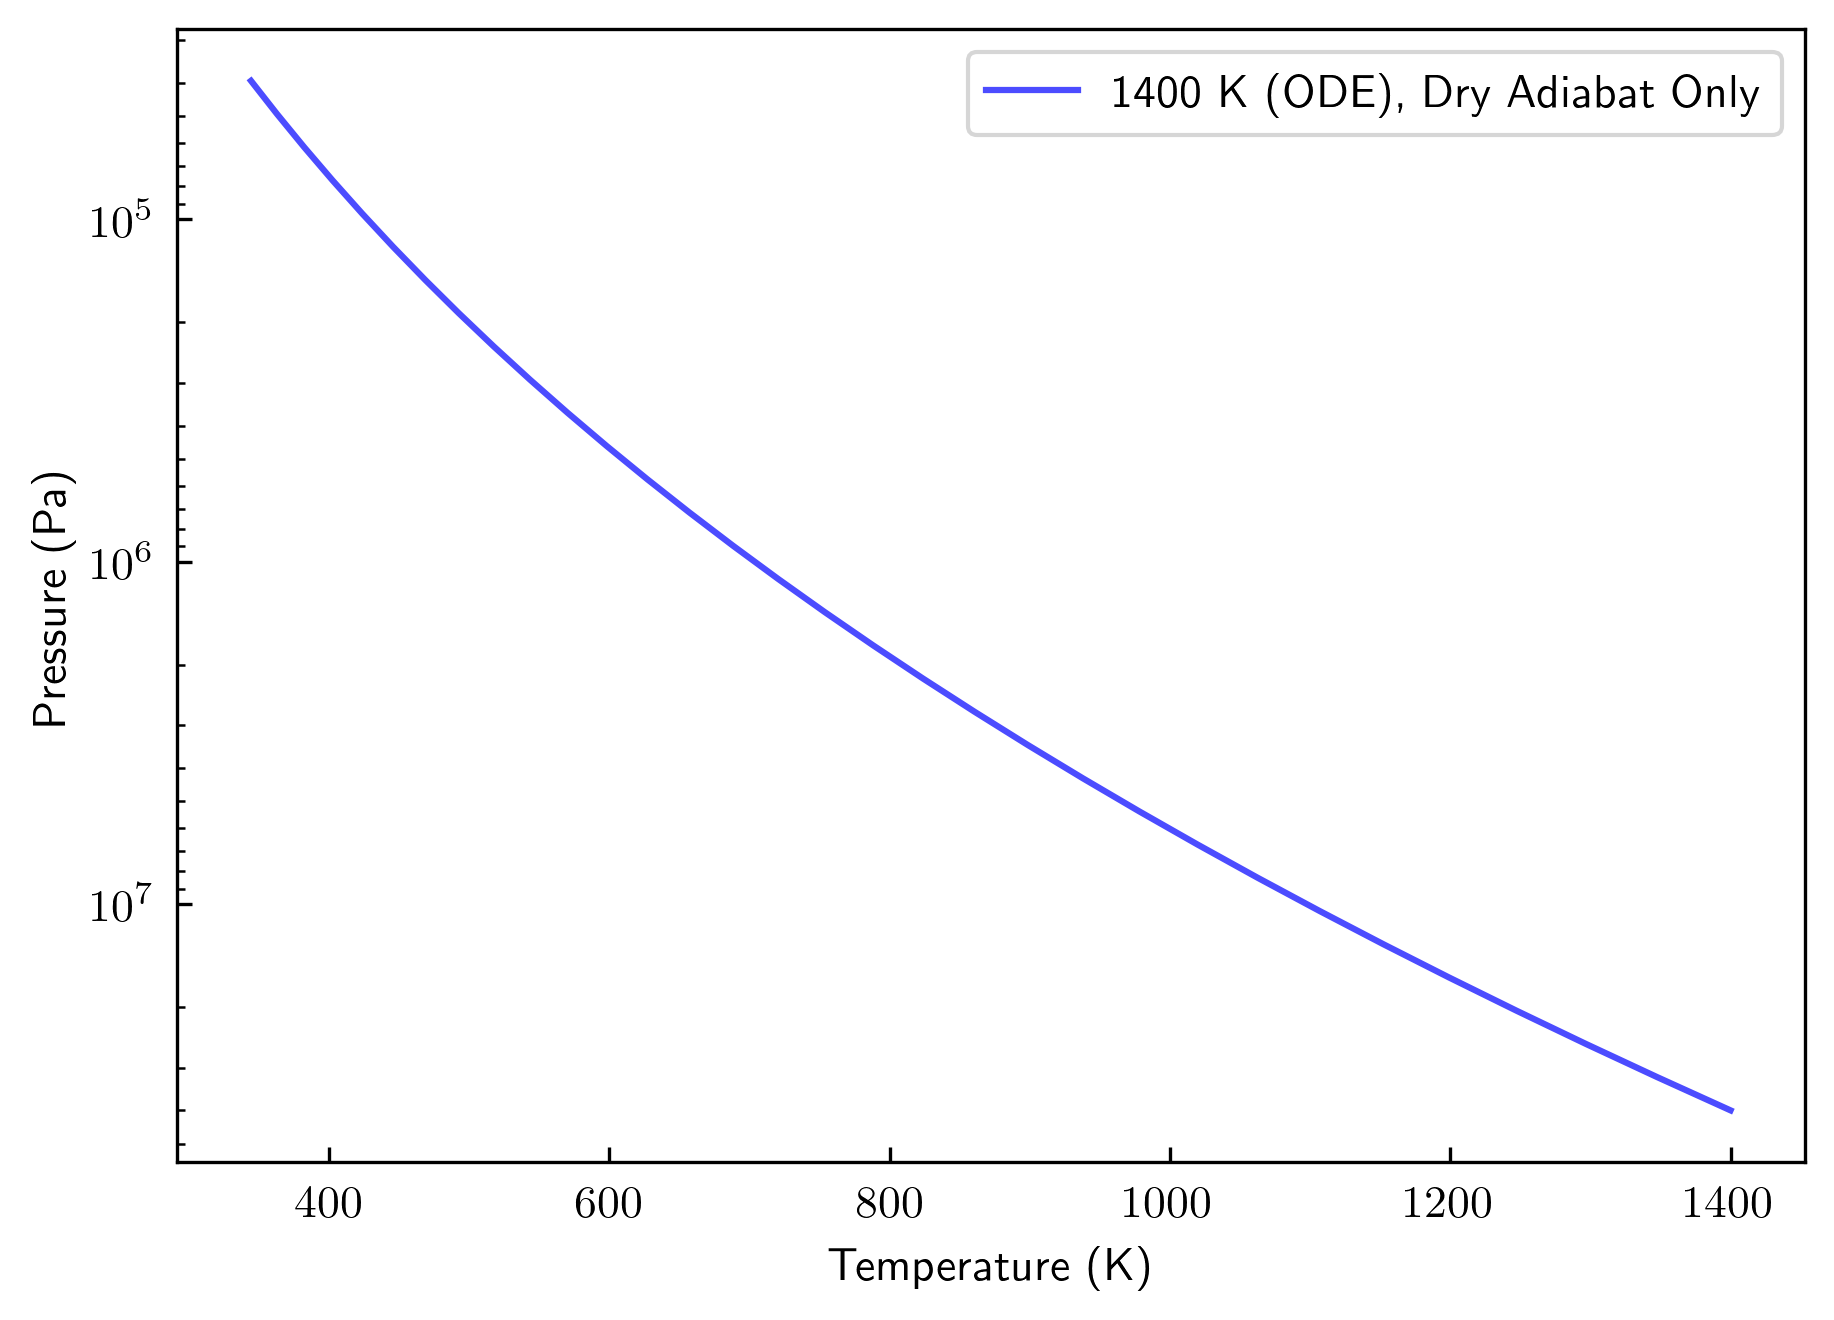

In [205]:
fig,ax = plt.subplots()
plt.plot(T_sol, P_sol, alpha=0.7, color='blue', label='1400 K (ODE), Dry Adiabat Only')
#plt.plot(T_sol_m, P_sol_m, alpha=0.7, color='green', label='1400 K (ODE) Moist Adiabat Only')
plt.xlabel('Temperature (K)')
plt.ylabel('Pressure (Pa)')
plt.gca().invert_yaxis()
plt.yscale('log')
#plt.xlim(0, 1400)
plt.legend()
#plt.savefig('TPProfs.jpg', dpi=1000)
plt.show()